<a href="https://colab.research.google.com/github/raja1996802/Udacity_Airbnb/blob/main/airbnb_seattle_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Business Understanding

**Business scenario**

The main question to break into the field is to find that, **how can I use the insights from the Seattle Airbnb data analysis to optimize my listing's pricing strategy and attract more guests to maximize my revenue and bookings?**.

To break into the field and answer the main question then three main questions has to be addressed and they are  

**Question-1**

 How the availability of Airbnb listings changes throughout the year and determine seasonal trends that may impact pricing and booking strategies for hosts ?

**Question-2**

How customer review scores impact the pricing of Airbnb listings, helping hosts understand the relationship between quality (as perceived by guests) and the price they can charge ?

**Question-3**

How relationship between the number of reviews a listing has been received and its booking success and why this in return helps identify the impact of reviews on occupancy rates ?




**Import the libraries and dependancies**


In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Set visualization style
sns.set(style="whitegrid")


#2.Data Understanding


**Gather data**

In [17]:
# Download the dataset from Kaggle

"""
The dataset is drectly downloaded from kaggle to avoid storing the dataset locally.
To do this intially kaggle library command is used to import the dependencies
"""
path = kagglehub.dataset_download("airbnb/seattle")

# Print the path to verify dataset location
print("Path to dataset files:", path)

# Load the listings and calendar data from the downloaded files
"""
Using Pandas function the datasets are assigned to the variable
  1.listings_df - basic information about the diffrent airbnb informations can be seen
  2.calendar_df - Information about the bookings made and price can be seen in this variable
"""
listings_df = pd.read_csv(f'{path}/listings.csv')
calendar_df = pd.read_csv(f'{path}/calendar.csv')

# To check first few rows of the listings dataset for viewing
print("Listings dataset:")
print(listings_df.head())

# To check first few rows of the calendar dataset for viewing
print("Calendar dataset:")
print(calendar_df.head())


Path to dataset files: /root/.cache/kagglehub/datasets/airbnb/seattle/versions/2
Listings dataset:
        id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita

#3. Data Preparation


**Clean data**

In [18]:
# Check for missing values in the listings dataset
missing_data_listings = listings_df.isnull().sum().sort_values(ascending=False)
print("Missing values in listings dataset:\n", missing_data_listings.head())

# Drop irrelevant columns or those with too many missing values from listings dataset
listings_df_cleaned = listings_df.drop(['license', 'square_feet', 'host_about', 'neighbourhood_group_cleansed'], axis=1)

# Fill missing values in important columns
listings_df_cleaned['reviews_per_month'].fillna(0, inplace=True)
listings_df_cleaned['price'] = listings_df_cleaned['price'].replace('[\$,]', '', regex=True).astype(float)

# Check for missing values in the calendar dataset
missing_data_calendar = calendar_df.isnull().sum().sort_values(ascending=False)
print("Missing values in calendar dataset:\n", missing_data_calendar.head())


Missing values in listings dataset:
 license             3818
square_feet         3721
monthly_price       2301
security_deposit    1952
weekly_price        1809
dtype: int64


<ipython-input-18-98bee0150320>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  listings_df_cleaned['reviews_per_month'].fillna(0, inplace=True)


Missing values in calendar dataset:
 price         459028
listing_id         0
date               0
available          0
dtype: int64


In [19]:
# Encode categorical features (room_type and property_type)
'''This code line uses the pandas library to create dummy variables for the 'room_type' and 'property_type' columns in the 'listings_df_cleaned' DataFrame.
The 'drop_first=True' parameter drops the first dummy variable for each category to avoid multicollinearity.
This code line uses the pandas library to create dummy variables for the 'room_type' and 'property_type' columns in the 'listings_df_cleaned' DataFrame.
The 'drop_first=True' parameter drops the first dummy variable for each category to avoid multicollinearity.'''

listings_df_cleaned = pd.get_dummies(listings_df_cleaned, columns=['room_type', 'property_type'], drop_first=True)

# Check the cleaned dataset
listings_df_cleaned.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Columns: 103 entries, id to property_type_Yurt
dtypes: bool(17), float64(16), int64(13), object(57)
memory usage: 2.6+ MB


# 4.Analyze and Data Modeling

**Correalation analysis with heat map**

This code is used to analyze the correlation between the 'price' column and other numeric columns in the dataset. It helps identify which features have a strong positive or negative correlation with the price of the listings. The heatmap visualization provides a quick overview of the relationships between variables

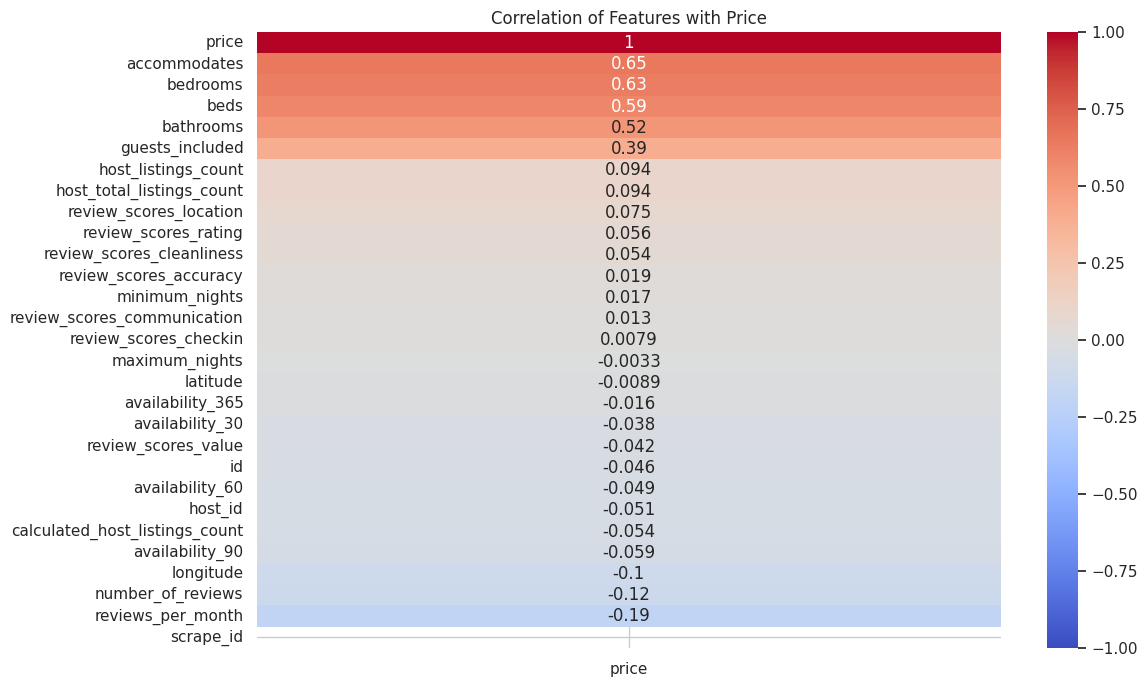

In [20]:

#-----------------------
# Clean and ensure 'price' column is numeric
listings_df_cleaned['price'] = listings_df_cleaned['price'].replace('[\$,]', '', regex=True).astype(float)

# Drop rows with missing values in the 'price' column
listings_df_cleaned = listings_df_cleaned.dropna(subset=['price'])

# Select numeric columns only for correlation
numeric_columns = listings_df_cleaned.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlation matrix
correlation = listings_df_cleaned[numeric_columns].corr()

# Plot correlation matrix with price
plt.figure(figsize=(12, 8))
sns.heatmap(correlation[['price']].sort_values(by='price', ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Features with Price')
plt.show()




In [21]:
# Convert the date column to datetime format in the calendar dataset
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

# Add year and month columns for easier analysis
calendar_df['year'] = calendar_df['date'].dt.year
calendar_df['month'] = calendar_df['date'].dt.month

# Calculate the availability rate per month
availability_by_month = calendar_df.groupby(['year', 'month'])['available'].apply(lambda x: (x == 't').mean()).reset_index()
availability_by_month.columns = ['year', 'month', 'availability_rate']



# 5. Evaluate the Results

**Question-1**

How the availability of Airbnb listings changes throughout the year and determine seasonal trends that may impact pricing and booking strategies for hosts ?

**Analyse and Visualise**

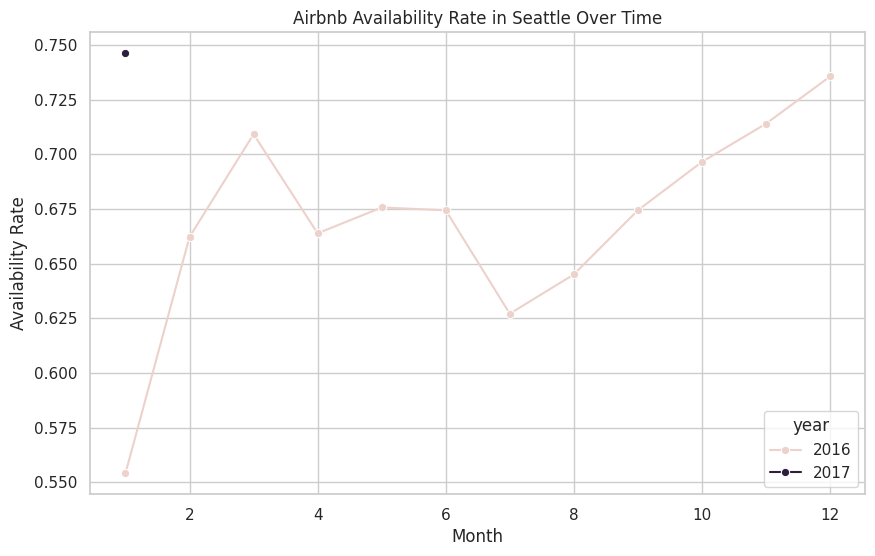

In [22]:
# Plot availability rate over time to analyze demand trends
plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='availability_rate', hue='year', data=availability_by_month, marker='o')
plt.title('Airbnb Availability Rate in Seattle Over Time')
plt.xlabel('Month')
plt.ylabel('Availability Rate')
plt.show()

**Explanation**

Availability rates are lower in summer, indicating high booking demand during tourist-heavy months (June–August). Higher availability rates in winter suggest fewer bookings during off-peak seasons (November–January).

**Question-2**

How customer review scores impact the pricing of Airbnb listings, helping hosts understand the relationship between quality (as perceived by guests) and the price they can charge ?


**Analyse and Visualise**

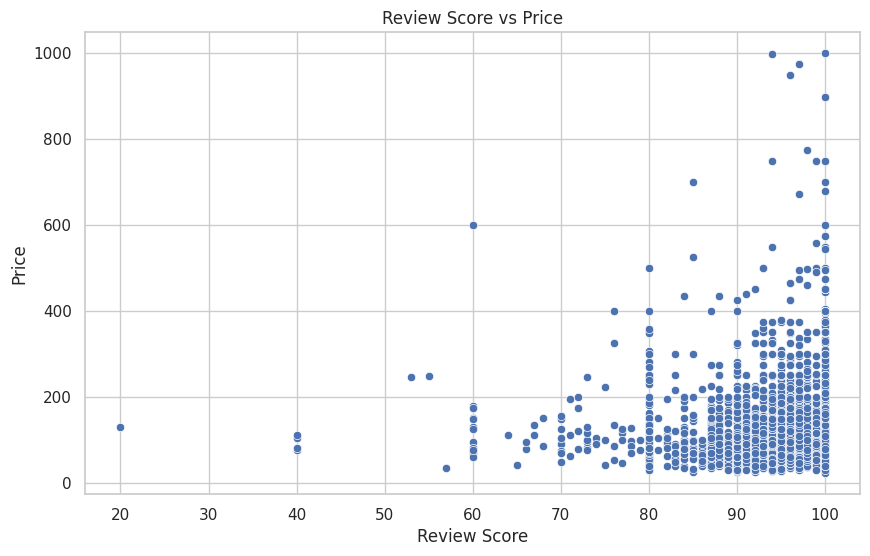

In [23]:
# Visualize the relationship between review scores and prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_scores_rating', y='price', data=listings_df_cleaned)
plt.title('Review Score vs Price')
plt.xlabel('Review Score')
plt.ylabel('Price')
plt.show()

**Explanation**

A positive correlation is observed: listings with higher review scores tend to have higher prices. However, there is variability in pricing even for similarly rated listings, indicating that other factors (like location or amenities) also influence prices.

**Question-3**

How relationship between the number of reviews a listing has been received and its booking success and why this in return helps identify the impact of reviews on occupancy rates ?


**Analyse and Visualise**

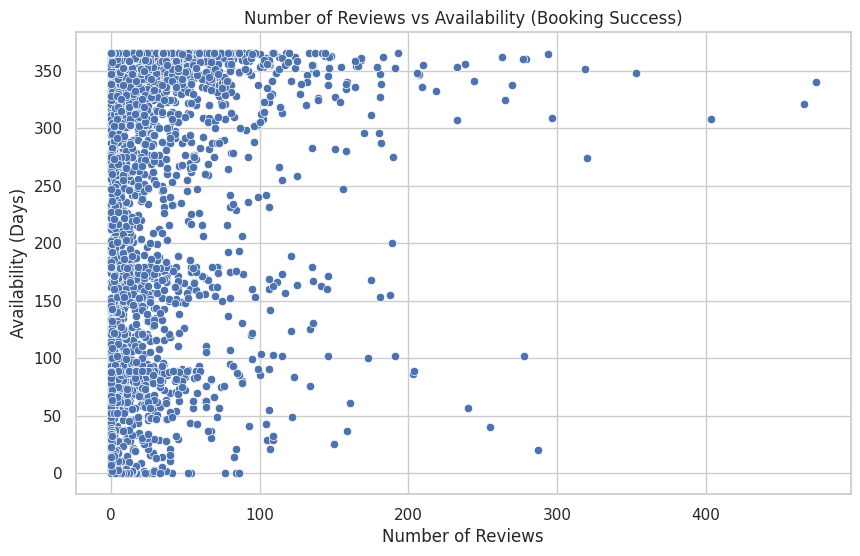

In [24]:
# Plot the relationship between the number of reviews and availability
plt.figure(figsize=(10, 6))
sns.scatterplot(x='number_of_reviews', y='availability_365', data=listings_df_cleaned)
plt.title('Number of Reviews vs Availability (Booking Success)')
plt.xlabel('Number of Reviews')
plt.ylabel('Availability (Days)')
plt.show()


**Explanation**

The scatter plot shows that listings with more reviews tend to have fewer available days, implying higher booking success. Listings with fewer reviews generally have more available days, indicating lower demand.